# 🛡️ Comment Toxicity Classification

## Project Overview
This notebook implements a **multi-label text classification model** to detect toxic comments using Deep Learning.

### The model identifies 6 types of toxicity:
| Label | Description |
|-------|-------------|
| **toxic** | Generally rude or disrespectful |
| **severe_toxic** | Very hateful or aggressive |
| **obscene** | Contains explicit language |
| **threat** | Contains threatening language |
| **insult** | Insulting or demeaning |
| **identity_hate** | Targets race, religion, gender, etc. |

---

# 0. Install Dependencies and Bring in Data

In [1]:
# =============================================================================
# INSTALL REQUIRED PACKAGES
# - tensorflow: Deep learning framework for building the neural network
# - pandas: Data manipulation and analysis
# - matplotlib: Visualization library
# - scikit-learn: Machine learning utilities and metrics
# - gradio: Interactive web interface for model demo
# - seaborn: Statistical data visualization
# =============================================================================
%pip install tensorflow pandas matplotlib scikit-learn gradio seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
# =============================================================================
# IMPORT ALL REQUIRED LIBRARIES
# =============================================================================
import os
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Data handling libraries
import pandas as pd
import numpy as np

# Deep Learning framework
import tensorflow as tf

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')

# Print version info for debugging
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.20.0
GPU Available: False


In [2]:
# =============================================================================
# LOAD THE TRAINING DATASET
# The Jigsaw Toxic Comment dataset contains ~160k comments with labels
# =============================================================================
DATA_PATH = os.path.join('jigsaw-toxic-comment-classification-challenge', 'train.csv', 'train.csv')
df = pd.read_csv(DATA_PATH)

# Display basic dataset information
print(f"Dataset Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")

Dataset Shape: 159,571 rows x 8 columns

Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [3]:
# =============================================================================
# EXPLORE THE DATA
# Preview first few rows to understand the structure
# =============================================================================
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


CLASS DISTRIBUTION ANALYSIS
toxic           -> 15,294 samples (9.58%)
severe_toxic    ->  1,595 samples (1.00%)
obscene         ->  8,449 samples (5.29%)
threat          ->    478 samples (0.30%)
insult          ->  7,877 samples (4.94%)
identity_hate   ->  1,405 samples (0.88%)


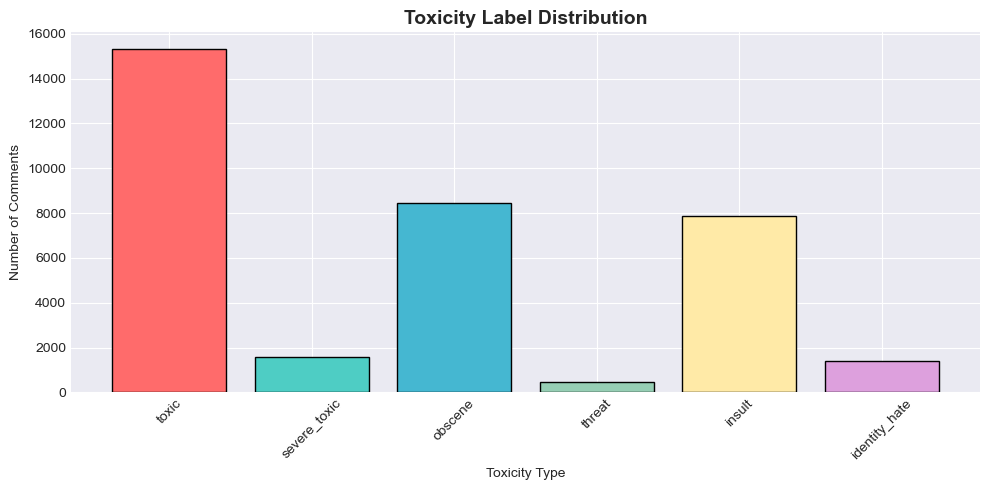

In [4]:
# =============================================================================
# ANALYZE CLASS DISTRIBUTION (Important for handling imbalanced data)
# =============================================================================
LABEL_COLS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)
for col in LABEL_COLS:
    count = df[col].sum()
    pct = (count / len(df)) * 100
    print(f"{col:15} -> {count:6,} samples ({pct:.2f}%)")

# Visualize class imbalance
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
class_counts = df[LABEL_COLS].sum()
bars = ax.bar(LABEL_COLS, class_counts.values, color=colors, edgecolor='black')
ax.set_title('Toxicity Label Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Comments')
ax.set_xlabel('Toxicity Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1. Preprocess

In [5]:
# =============================================================================
# IMPORT TEXT VECTORIZATION LAYER
# This converts text strings into sequences of integers
# =============================================================================
from tensorflow.keras.layers import TextVectorization

In [6]:
# =============================================================================
# PREPARE FEATURES (X) AND LABELS (y)
# X: The comment text (input)
# y: Multi-label array with 6 toxicity columns (output)
# =============================================================================
X = df['comment_text']  # Input: raw text comments
y = df[df.columns[2:]].values  # Output: 6-column label array

print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")
print(f"\nSample comment preview:\n{X.iloc[0][:200]}...")

Input shape: (159571,)
Output shape: (159571, 6)

Sample comment preview:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove th...


In [7]:
# =============================================================================
# CONFIGURE TEXT VECTORIZATION PARAMETERS
# - MAX_FEATURES: Maximum vocabulary size (unique words to keep)
# - MAX_SEQUENCE_LENGTH: Maximum length of each text sequence
# - Longer sequences are truncated, shorter ones are padded
# =============================================================================
MAX_FEATURES = 200000  # Vocabulary size: top 200k most frequent words
MAX_SEQUENCE_LENGTH = 1800  # Maximum sequence length

In [8]:
# =============================================================================
# CREATE TEXT VECTORIZATION LAYER
# This layer will:
# 1. Tokenize text into words
# 2. Convert words to integer indices
# 3. Pad/truncate to fixed length
# =============================================================================
vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,           # Max vocabulary size
    output_sequence_length=1800,       # Fixed output length
    output_mode='int'                  # Output integer indices
)
print("TextVectorization layer created!")

TextVectorization layer created!


In [9]:
# =============================================================================
# ADAPT VECTORIZER TO THE CORPUS
# This learns the vocabulary from the training data
# =============================================================================
print("Adapting vectorizer to corpus... (this may take a minute)")
vectorizer.adapt(X.values)
print(f"✅ Vocabulary size: {len(vectorizer.get_vocabulary()):,} words")

Adapting vectorizer to corpus... (this may take a minute)
✅ Vocabulary size: 200,000 words


In [10]:
# =============================================================================
# VECTORIZE ALL TEXT DATA
# Convert all comments to integer sequences
# =============================================================================
print("Vectorizing all comments...")
vectorized_text = vectorizer(X.values)
print(f"✅ Vectorized shape: {vectorized_text.shape}")

Vectorizing all comments...
✅ Vectorized shape: (159571, 1800)


In [11]:
# =============================================================================
# CREATE TF.DATA PIPELINE
# Using MCSHBAP pattern: Map, Cache, Shuffle, Batch, Prefetch
# This creates an efficient data pipeline for training
# =============================================================================
BATCH_SIZE = 16
BUFFER_SIZE = 160000  # Shuffle buffer size

# Create dataset from tensors
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()                      # Cache data in memory
dataset = dataset.shuffle(BUFFER_SIZE)         # Shuffle for randomness
dataset = dataset.batch(BATCH_SIZE)            # Create batches
dataset = dataset.prefetch(tf.data.AUTOTUNE)   # Prefetch for GPU efficiency

print(f"✅ Dataset created with {len(dataset):,} batches")

✅ Dataset created with 9,974 batches


In [12]:
# =============================================================================
# SPLIT DATA INTO TRAIN, VALIDATION, AND TEST SETS
# - Train: 70% - Used to train the model
# - Validation: 20% - Used to tune hyperparameters
# - Test: 10% - Used for final evaluation
# =============================================================================
total_batches = len(dataset)
train_size = int(total_batches * 0.7)
val_size = int(total_batches * 0.2)

train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + val_size)

print(f"Train batches: {len(train):,}")
print(f"Validation batches: {len(val):,}")
print(f"Test batches: {len(test):,}")

Train batches: 6,981
Validation batches: 1,994
Test batches: 999


# 2. Create Sequential Model

In [13]:
# =============================================================================
# IMPORT KERAS LAYERS FOR MODEL BUILDING
# =============================================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, Dropout, Bidirectional, Dense, Embedding, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [14]:
# =============================================================================
# BUILD THE ENHANCED BIDIRECTIONAL LSTM MODEL
# 
# Architecture:
# 1. Embedding Layer: Converts word indices to dense vectors
# 2. Bidirectional LSTM: Processes text in both directions
# 3. BatchNormalization: Stabilizes training
# 4. Dense Layers: Feature extraction with dropout for regularization
# 5. Output Layer: Sigmoid activation for multi-label classification
# =============================================================================

model = Sequential([
    # Embedding layer: Convert word indices to 32-dimensional vectors
    Embedding(input_dim=MAX_FEATURES + 1, output_dim=32, name='embedding'),
    
    # Bidirectional LSTM: Processes sequence in both forward and backward directions
    # This helps capture context from both past and future words
    Bidirectional(LSTM(32, activation='tanh', return_sequences=False), name='bilstm'),
    
    # Batch Normalization: Normalizes layer outputs for stable training
    BatchNormalization(name='batch_norm'),
    
    # Dense layers with dropout for feature extraction
    Dense(128, activation='relu', name='dense_1'),
    Dropout(0.3, name='dropout_1'),  # 30% dropout to prevent overfitting
    
    Dense(256, activation='relu', name='dense_2'),
    Dropout(0.3, name='dropout_2'),
    
    Dense(128, activation='relu', name='dense_3'),
    Dropout(0.2, name='dropout_3'),
    
    # Output layer: 6 neurons with sigmoid for multi-label classification
    # Sigmoid outputs probability (0-1) for each toxicity type independently
    Dense(6, activation='sigmoid', name='output')
])

print("✅ Model architecture created!")

✅ Model architecture created!


In [15]:
# =============================================================================
# COMPILE THE MODEL
# - Loss: BinaryCrossentropy is used for multi-label classification
# - Optimizer: Adam with learning rate scheduling
# - Metrics: Track accuracy, precision, recall, and AUC
# =============================================================================
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
print("✅ Model compiled!")

✅ Model compiled!


In [16]:
# =============================================================================
# DISPLAY MODEL SUMMARY
# Shows layer architecture and parameter counts
# =============================================================================
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# =============================================================================
# SETUP TRAINING CALLBACKS
# Callbacks help optimize training and prevent overfitting
# =============================================================================
callbacks = [
    # Early Stopping: Stop training when validation metric stops improving
    EarlyStopping(
        monitor='val_auc',       # Monitor validation AUC
        patience=2,              # Wait 2 epochs before stopping
        mode='max',              # We want to maximize AUC
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce LR on Plateau: Reduce learning rate when training stalls
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,              # Reduce LR by half
        patience=1,              # After 1 epoch of no improvement
        min_lr=1e-6,
        verbose=1
    )
]

print("✅ Training callbacks configured!")

✅ Training callbacks configured!


In [ ]:
# =============================================================================
# TRAIN THE MODEL
# =============================================================================
EPOCHS = 5  # Number of training epochs (early stopping will prevent overfitting)

print("="*60)
print("STARTING MODEL TRAINING")
print("="*60)

history = model.fit(
    train,
    epochs=EPOCHS,
    validation_data=val,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")

STARTING MODEL TRAINING
Epoch 1/5
1166/6981 ━━━━━━━━━━━━━━━━━━━━ 47:47 493ms/step - accuracy: 0.9619 - auc: 0.8107 - loss: 0.1502 - precision: 0.4236 - recall: 0.0924

In [ ]:
# =============================================================================
# VISUALIZE TRAINING HISTORY
# Plot loss and metrics over epochs to check for overfitting
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', color='#FF6B6B', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', color='#4ECDC4', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', color='#FF6B6B', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', color='#4ECDC4', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: AUC-ROC
axes[1, 0].plot(history.history['auc'], label='Train AUC', color='#FF6B6B', linewidth=2)
axes[1, 0].plot(history.history['val_auc'], label='Val AUC', color='#4ECDC4', linewidth=2)
axes[1, 0].set_title('Model AUC-ROC', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision', color='#FF6B6B', linewidth=2)
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', color='#4ECDC4', linewidth=2)
axes[1, 1].plot(history.history['recall'], label='Train Recall', color='#FFB347', linewidth=2, linestyle='--')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', color='#96CEB4', linewidth=2, linestyle='--')
axes[1, 1].set_title('Precision & Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Make Predictions

In [ ]:
# =============================================================================
# TEST PREDICTION ON A SAMPLE COMMENT
# =============================================================================
sample_text = 'You freaking suck! I am going to hit you.'
input_text = vectorizer([sample_text])  # Wrap in list for batch dimension

print(f"Input text: '{sample_text}'")
print(f"Vectorized shape: {input_text.shape}")

In [ ]:
# =============================================================================
# GET MODEL PREDICTIONS
# Returns probability scores (0-1) for each toxicity type
# =============================================================================
res = model.predict(input_text)

print("\nPrediction probabilities:")
for label, prob in zip(LABEL_COLS, res[0]):
    status = "⚠️ TOXIC" if prob > 0.5 else "✓ OK"
    print(f"  {label:15}: {prob:.4f} {status}")

In [ ]:
# =============================================================================
# CONVERT PROBABILITIES TO BINARY PREDICTIONS
# Threshold of 0.5: values > 0.5 are considered positive
# =============================================================================
binary_predictions = (res > 0.5).astype(int)
print("Binary predictions (1=Toxic, 0=Not Toxic):")
print(binary_predictions)

In [ ]:
# =============================================================================
# TEST ON A BATCH FROM TEST SET
# =============================================================================
batch_X, batch_y = test.as_numpy_iterator().next()
print(f"Batch shape: {batch_X.shape}")
print(f"Labels shape: {batch_y.shape}")

In [ ]:
# =============================================================================
# PREDICT ON TEST BATCH
# =============================================================================
batch_predictions = (model.predict(batch_X) > 0.5).astype(int)
print(f"Predictions for first 5 samples:")
print(batch_predictions[:5])

# 4. Evaluate Model

In [ ]:
# =============================================================================
# IMPORT ADDITIONAL EVALUATION METRICS
# =============================================================================
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC

In [ ]:
# =============================================================================
# COLLECT ALL TEST PREDICTIONS
# =============================================================================
print("Evaluating on test set...")

y_true_list = []
y_pred_list = []

for batch_x, batch_y in test:
    y_pred_batch = model.predict(batch_x, verbose=0)
    y_true_list.append(batch_y.numpy())
    y_pred_list.append(y_pred_batch)

y_true = np.vstack(y_true_list)
y_pred_proba = np.vstack(y_pred_list)
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"✅ Evaluated on {len(y_true):,} test samples")

In [ ]:
# =============================================================================
# DETAILED CLASSIFICATION REPORT
# Shows precision, recall, and F1-score for each class
# =============================================================================
print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=LABEL_COLS, zero_division=0))

In [ ]:
# =============================================================================
# PER-CLASS METRICS (AUC-ROC is critical for imbalanced data)
# =============================================================================
print("="*60)
print("PER-CLASS AUC-ROC SCORES")
print("="*60)

for i, col in enumerate(LABEL_COLS):
    auc = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
    f1 = f1_score(y_true[:, i], y_pred[:, i])
    print(f"{col:15} | AUC: {auc:.4f} | F1: {f1:.4f}")

# Overall metrics
print("\n" + "="*60)
overall_auc = roc_auc_score(y_true, y_pred_proba, average='macro')
overall_f1 = f1_score(y_true, y_pred, average='macro')
print(f"OVERALL MACRO AUC-ROC: {overall_auc:.4f}")
print(f"OVERALL MACRO F1-SCORE: {overall_f1:.4f}")
print("="*60)

In [ ]:
# =============================================================================
# CONFUSION MATRICES VISUALIZATION
# Shows true positives, false positives, true negatives, false negatives
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (ax, col) in enumerate(zip(axes, LABEL_COLS)):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not Toxic', 'Toxic'],
                yticklabels=['Not Toxic', 'Toxic'])
    ax.set_title(f'{col.upper()}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.suptitle('Confusion Matrices by Toxicity Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 5. Test and Gradio

In [ ]:
# =============================================================================
# INSTALL GRADIO FOR INTERACTIVE INTERFACE
# =============================================================================
!pip install gradio --quiet

In [ ]:
# =============================================================================
# IMPORT GRADIO
# =============================================================================
import gradio as gr
print(f"Gradio version: {gr.__version__}")

In [ ]:
# =============================================================================
# SAVE THE TRAINED MODEL
# Using modern .keras format (Keras 3 compatible)
# =============================================================================
model.save('toxicity.keras')
print("✅ Model saved to 'toxicity.keras'")

In [ ]:
# =============================================================================
# LOAD THE SAVED MODEL (simulates deployment scenario)
# =============================================================================
loaded_model = tf.keras.models.load_model('toxicity.keras')
print("✅ Model loaded successfully!")

In [ ]:
# =============================================================================
# TEST LOADED MODEL
# =============================================================================
test_text = 'hey i freaken hate you!'
input_str = vectorizer([test_text])
res = loaded_model.predict(input_str)

print(f"Test text: '{test_text}'")
print("\nPredictions:")
for label, prob in zip(LABEL_COLS, res[0]):
    print(f"  {label}: {prob:.4f}")

In [ ]:
# =============================================================================
# CREATE SCORING FUNCTION FOR GRADIO INTERFACE
# =============================================================================
def score_comment(comment):
    """
    Analyze a comment for different types of toxicity.
    
    Args:
        comment: Input text to analyze
        
    Returns:
        Dictionary of toxicity scores for each category
    """
    if not comment or not comment.strip():
        return {label: 0.0 for label in LABEL_COLS}
    
    # Vectorize the input comment
    vectorized_comment = vectorizer([comment])
    
    # Get predictions from model
    results = loaded_model.predict(vectorized_comment, verbose=0)
    
    # Return as dictionary (works with gr.Label)
    return {label: float(score) for label, score in zip(LABEL_COLS, results[0])}

In [ ]:
# =============================================================================
# CREATE GRADIO INTERFACE
# Modern Gradio API (compatible with Gradio 4.x)
# =============================================================================
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(
        label="Enter Comment",
        placeholder="Type a comment to analyze for toxicity...",
        lines=3
    ),
    outputs=gr.Label(
        label="Toxicity Scores",
        num_top_classes=6
    ),
    title="🛡️ Comment Toxicity Analyzer",
    description="""Analyze comments for different types of toxicity:
    **toxic** | **severe_toxic** | **obscene** | **threat** | **insult** | **identity_hate**""",
    examples=[
        ["You did a great job on this project!"],
        ["This is terrible and you should be ashamed."],
        ["I disagree with your opinion but respect it."],
    ],
    theme=gr.themes.Soft()
)

print("✅ Gradio interface created!")

In [ ]:
# =============================================================================
# LAUNCH THE INTERACTIVE INTERFACE
# share=True creates a public URL for sharing
# =============================================================================
interface.launch(share=True)

---

## 📊 Summary

This notebook implements a **Comment Toxicity Classification** model with:

### Model Architecture
- **Embedding Layer**: Converts words to dense vectors
- **Bidirectional LSTM**: Captures context from both directions
- **BatchNormalization**: Stabilizes training
- **Dense + Dropout**: Feature extraction with regularization

### Training Features
- **EarlyStopping**: Prevents overfitting
- **ReduceLROnPlateau**: Adaptive learning rate
- **Multiple Metrics**: Accuracy, Precision, Recall, AUC

### Evaluation
- Per-class AUC-ROC scores
- Confusion matrices
- Classification report

---